# Learning to solve nonlinear ODE reference tracking problem

Using [Differentiable predictive control (DPC) method](https://www.sciencedirect.com/science/article/pii/S0959152422000981) to learn parametric neural control policy for reference tracking of nonlinear ordinary differential equations (ODE).

Example adopted from: https://apmonitor.com/do/index.php/Main/LevelControl

## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install neuromancer

*Note: When running on Colab, one might encounter a pip dependency error with Lida 0.0.10. This can be ignored*

In [11]:
import torch
import torch.nn as nn
import numpy as np

import neuromancer.psl as psl
from neuromancer.system import Node, System, SystemPreview
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.dynamics import ode, integrators
from neuromancer.plot import pltCL, pltPhase

## System model 

Lets consider the following system of two connected tanks controlled by a single pump and a two way valve.
The system is a simplified model of a [pumped-storage hydroelectricity](https://en.wikipedia.org/wiki/Pumped-storage_hydroelectricity) which is a type of hydroelectric energy storage used by electric power systems for [load balancing](https://en.wikipedia.org/wiki/Load_balancing_(electrical_power). 

**System schematics**:  
<img src="../figs/two_tank_level.png" width="250">  

**System model**:  
The system dynamics is defined by following nonlinear ordinary differential equations (ODEs):
$$
 \frac{dx_1}{dt} = c_1 (1.0 - v)  p - c_2  \sqrt{x_1}  \\  
 \frac{dx_2}{dt}  = c_1 v p + c_2  \sqrt{x_1} - c_2 \sqrt{x_2}
$$  
With system states $x_1$, and $x_2$ representing liquid levels in tank 1 and 2, respectively. Control actions are pump modulation $p$, and valve opening $v$. The ODE system is parametrized by inlet and outlet valve coefficients $c_1$ and $c_2$, respectively.

**Control ojective**:   
The objective is to control the tank levels into desired reference values by modulating the pump and valve control actions.

System model and image adopted from: https://apmonitor.com/do/index.php/Main/LevelControl

In [12]:
# ground truth system model
gt_model = psl.nonautonomous.TwoTank()
# sampling rate
ts = gt_model.params[1]['ts']
# problem dimensions
nx = gt_model.nx    # number of states
nu = gt_model.nu    # number of control inputs
nref = nx           # number of references
# constraints bounds
umin = 0
umax = 1.
xmin = 0
xmax = 1.

# Differentiable Predictive Control 

Next we show how to solve the corresponding parametric optimal control using the [DPC method](https://www.sciencedirect.com/science/article/pii/S0959152422000981) implemented in Neuromancer.

**Schematics of the Differentiable Predictive Control method**:  
<img src="./figs/DPC_simple_method.png" width="600">  

**Neural control policy**:  
The objective of this tutorial is to learn neural control policy $u_k = \pi(x_k, R)$ to control the tank levels by modulating the pump and valve control actions $u_k = [p_k, v_k]$. The policy takes in the measurements of system states $x_k$ at thime $k$ and desired references $R = [r_k, ..., r_{k+N}]$ over pre-defined horizon $N$. This tutorial shows how to construct a DPC policy in scenarios where future references $[r_{k+1}, ..., r_{k+N}]$ are known and where they are unknown.

**Differentiable system model**:  
The DPC is a model-based policy optimization algorithm, that exploits the differentiability of a wide class of model representations for dynamical systems, including differential equations, state-space models, or various neural network architectures. In this example, we compactly represent the system model by ODE equations  $\text{ODESolve}(f(x^i_k, u^i_k))$  describing the governing dynamics of the controlled system. 

**Differentiable predictive control problem formulation**:  
We learn the explicit neural control policy by solving the following parametric optimal control problem: 
$$
\begin{align}
&\underset{\theta}{\text{minimize}}     && \sum_{i=1}^m  \Big( \sum_{k=1}^{N-1} Q_x||x^i_k - r^i_k||_2^2  + Q_N||x^i_N - r^i_N||_2^2 \Big) \\
&\text{subject to}    && x^i_{k+1} =  \text{ODESolve}(f(x^i_k, u^i_k)) \\
&                     && u^i_k = \pi_{\theta}(x^i_k, R^i) \\
&                     && 0 \le x^i_k \le 1 \\
&                     && 0 \le u^i_k \le 1 \\
&                     && x^i_0 \sim \mathcal{P}_{x_0} \\
&                     && R^i \sim  \mathcal{P}_R
\end{align}
$$  
The objective function is to minimize the reference tracking error $||x^i_k - r^i_k||_2^2$ over pre-defined prediction horizon $N$ weighted by a scalar $Q_x$, including terminal penalty weighted by $Q_N$.  The parametric neural control policy is given by $\pi_{\theta}(x^i_k, R^i)$. The neural control policy is optimized over a problem parameters sampled from the distributions $\mathcal{P}_{x_0}$, and $\mathcal{P}_R$, for state initial conditions, and references, respectively. The parameters $\theta$ are optimized with stochastic gradient descent.

## Training dataset generation

For a training dataset we randomly sample initial conditions of states and sequence of admissible reference trajectories over predefined prediction horizon from given distributions $\mathcal{P}_{x_0}$, and $\mathcal{P}_R$, respectively.

In [13]:
nsteps = 30  # prediction horizon
n_samples = 2000    # number of sampled scenarios

#  sampled references for training the policy
list_refs = [torch.rand(1, 1)*torch.ones(nsteps+1, nref) for k in range(n_samples)]
ref = torch.cat(list_refs)
batched_ref = ref.reshape([n_samples, nsteps+1, nref])
# Training dataset
train_data = DictDataset({'x': torch.rand(n_samples, 1, nx),   # sampled initial conditions of states
                          'r': batched_ref}, name='train')

# sampled references for development set
list_refs = [torch.rand(1, 1)*torch.ones(nsteps+1, nref) for k in range(n_samples)]
ref = torch.cat(list_refs)
batched_ref = ref.reshape([n_samples, nsteps+1, nref])
# Development dataset
dev_data = DictDataset({'x': torch.rand(n_samples, 1, nx),    # sampled initial conditions of states
                        'r': batched_ref}, name='dev')

# torch dataloaders
batch_size = 200
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           collate_fn=train_data.collate_fn,
                                           shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=batch_size,
                                         collate_fn=dev_data.collate_fn,
                                         shuffle=False)

## System model and Control policy in Neuromancer

Here we construct a closed-loop systems as differentiable computational graphs by connecting the system dynamics model  $x_{k+1} = \text{ODESolve}(f(x_k, u_k))$ with neural control policies $u_k = \pi_{\theta}(x_k, r_k)$ or $u_k = \pi_{\theta}(x_k, R)$, in case future disturbances are known. Hence we obtain a trainable system architectures: 

1. Without preview of future references $x_{k+1} = \text{ODESolve}(f(x_k, \pi_{\theta}(x_k, r_k)))$,
2. With preview of future references $x_{k+1} = \text{ODESolve}(f(x_k, \pi_{\theta}(x_k, R)))$.

Notice how size of input layers differs in case 1. case 2.

In [14]:
# white-box ODE model with no-plant model mismatch
two_tank_ode = ode.TwoTankParam()                   # ODE system equations implemented in PyTorch
two_tank_ode.c1 = nn.Parameter(torch.tensor(gt_model.c1), requires_grad=False)
two_tank_ode.c2 = nn.Parameter(torch.tensor(gt_model.c2), requires_grad=False)

# integrate continuous time ODE
integrator = integrators.RK4(two_tank_ode, h=torch.tensor(ts))   # using 4th order runge kutta integrator
# symbolic system model
model = Node(integrator, ['x', 'u'], ['x'], name='model')

# neural net control policy with hard control action bounds
net = blocks.MLP_bounds(insize=nx + nref, outsize=nu, hsizes=[32, 32],
                    nonlin=activations['gelu'], min=umin, max=umax)
policy = Node(net, ['x', 'r'], ['u'], name='policy')

# closed-loop system model
cl_system = System([policy, model], nsteps=nsteps)
# cl_system.show()

# neural net control policy with reference preview
net_preview = blocks.MLP_bounds(insize=nx + (nref*(nsteps+1)), outsize=nu, hsizes=[64, 32],
                    nonlin=activations['gelu'], min=umin, max=umax)
policy_with_preview = Node(net_preview, ['x', 'r'], ['u'], name='policy')

cl_system_preview = SystemPreview([policy_with_preview, model], name='cl_system_preview',
                nsteps=nsteps, preview_keys_map={'r': ['policy']}, # reference preview for neural control policy node
                preview_length={'r': nsteps}, pad_mode='replicate') # replicate last sample in the sequence

## Differentiable Predictive Control objectives and constraints

Here we take advantage of Neuromancer's high level symbolic language to define objective and constraint terms of our optimal control problem.

In [15]:
# variables
x = variable('x')
ref = variable("r")
# objectives
regulation_loss = 5. * ((x == ref) ^ 2)  # target posistion
# constraints
state_lower_bound_penalty = 10.*(x > xmin)
state_upper_bound_penalty = 10.*(x < xmax)
terminal_lower_bound_penalty = 10.*(x[:, [-1], :] > ref-0.01)
terminal_upper_bound_penalty = 10.*(x[:, [-1], :] < ref+0.01)
# objectives and constraints names for nicer plot
regulation_loss.name = 'state_loss'
state_lower_bound_penalty.name = 'x_min'
state_upper_bound_penalty.name = 'x_max'
terminal_lower_bound_penalty.name = 'y_N_min'
terminal_upper_bound_penalty.name = 'y_N_max'
# list of constraints and objectives
objectives = [regulation_loss]
constraints = [
    state_lower_bound_penalty,
    state_upper_bound_penalty,
    terminal_lower_bound_penalty,
    terminal_upper_bound_penalty,
]

## Differentiable optimal control problem s

Here we put things together to construct a differentibale optimal control problems for both cases.

In [16]:
# data (x_k, r_k) -> parameters (xi_k) -> policy (u_k) -> dynamics (x_{k+1})
components = [cl_system]
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)
# plot computational graph
# problem.show()
# data (x_k, [r_k, ..., r_{k+N}]) -> parameters (xi_k) -> policy (u_k) -> dynamics (x_{k+1})
problem_with_preview = Problem([cl_system_preview], loss)

## Solve the problems

We solve the problems using stochastic gradient descent over pre-defined training data of sampled parameters.

In [17]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=0.002)
#  Neuromancer trainer
trainer = Trainer(
    problem,
    train_loader, dev_loader,
    optimizer=optimizer,
    epochs=100,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=50, 
)
# Train control policy
best_model = trainer.train()
# load best trained model
trainer.model.load_state_dict(best_model)


epoch: 0  train_loss: 4.342977046966553
epoch: 1  train_loss: 3.814634323120117
epoch: 2  train_loss: 3.3746330738067627
epoch: 3  train_loss: 2.934001922607422
epoch: 4  train_loss: 2.4217379093170166
epoch: 5  train_loss: 1.9056155681610107
epoch: 6  train_loss: 1.584114909172058
epoch: 7  train_loss: 1.466281533241272
epoch: 8  train_loss: 1.378718376159668
epoch: 9  train_loss: 1.2880938053131104
epoch: 10  train_loss: 1.209263801574707
epoch: 11  train_loss: 1.1395562887191772
epoch: 12  train_loss: 1.0728957653045654
epoch: 13  train_loss: 1.0160235166549683
epoch: 14  train_loss: 0.9665754437446594
epoch: 15  train_loss: 0.9257206916809082
epoch: 16  train_loss: 0.8920843005180359
epoch: 17  train_loss: 0.8637102246284485
epoch: 18  train_loss: 0.8395044207572937
epoch: 19  train_loss: 0.8192031979560852
epoch: 20  train_loss: 0.8020221590995789
epoch: 21  train_loss: 0.7874384522438049
epoch: 22  train_loss: 0.7748552560806274
epoch: 23  train_loss: 0.7645717859268188
epoch: 24

<All keys matched successfully>

In [18]:
optimizer_ = torch.optim.Adam(problem_with_preview.parameters(), lr=0.01, weight_decay=0.002)
trainer_with_preview = Trainer(
        problem_with_preview,
        train_loader, dev_loader,
        optimizer=optimizer_,
        epochs=150,
        train_metric='train_loss',
        eval_metric='dev_loss',
        warmup=5,
        patience=50
    )
# Train control policy with reference preview
best_model_preview = trainer_with_preview.train()
# Load best model with reference preview
trainer_with_preview.model.load_state_dict(best_model_preview)

epoch: 0  train_loss: 3.3042984008789062
epoch: 1  train_loss: 2.128328800201416
epoch: 2  train_loss: 1.6303514242172241
epoch: 3  train_loss: 1.3769407272338867
epoch: 4  train_loss: 1.2582385540008545
epoch: 5  train_loss: 1.142716646194458
epoch: 6  train_loss: 1.0894454717636108
epoch: 7  train_loss: 1.0725719928741455
epoch: 8  train_loss: 1.003190279006958
epoch: 9  train_loss: 0.9772284626960754
epoch: 10  train_loss: 0.9645615816116333
epoch: 11  train_loss: 0.926988422870636
epoch: 12  train_loss: 0.9258063435554504
epoch: 13  train_loss: 0.973685085773468
epoch: 14  train_loss: 0.9755759239196777
epoch: 15  train_loss: 0.9181258082389832
epoch: 16  train_loss: 0.8733503222465515
epoch: 17  train_loss: 0.8487941026687622
epoch: 18  train_loss: 0.8582565188407898
epoch: 19  train_loss: 0.8655278086662292
epoch: 20  train_loss: 0.8008065223693848
epoch: 21  train_loss: 0.7953435182571411
epoch: 22  train_loss: 0.7637227773666382
epoch: 23  train_loss: 0.7748426795005798
epoch: 

<All keys matched successfully>

# Evaluate best model on a system rollout


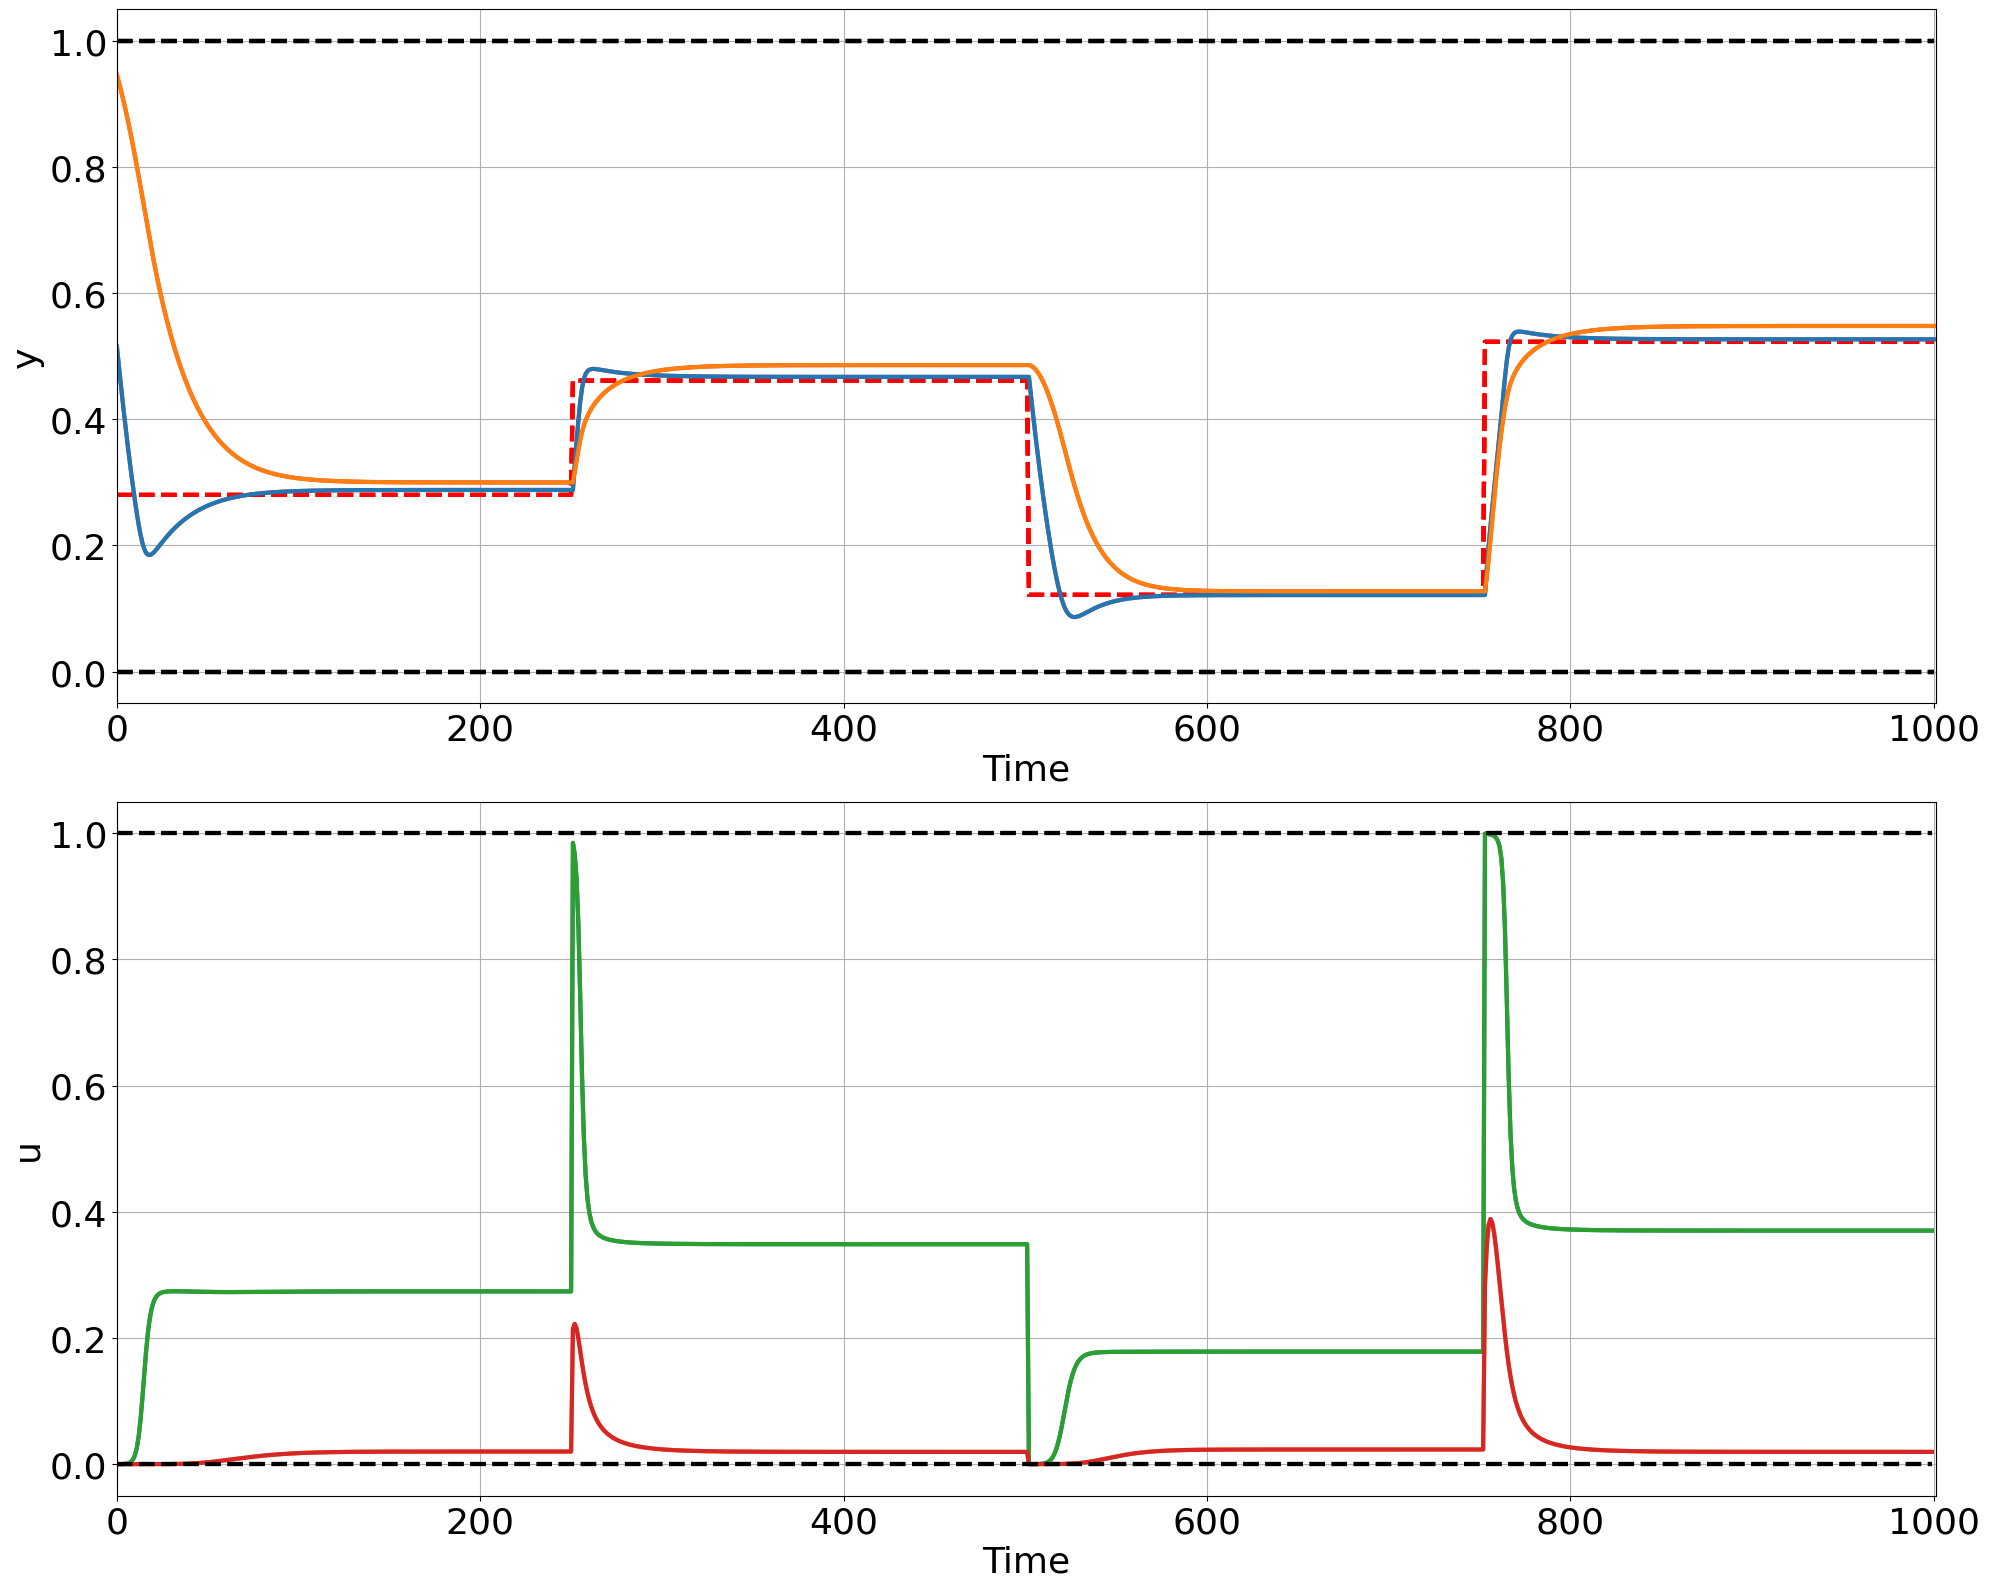

<Figure size 640x480 with 0 Axes>

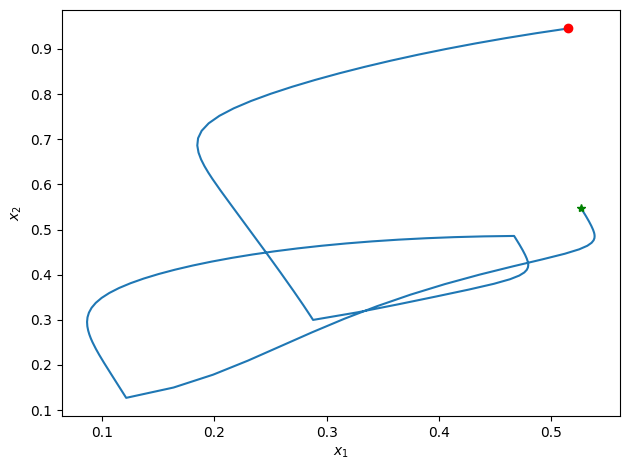

<Figure size 640x480 with 0 Axes>

In [19]:
nsteps = 1000
step_length = 250
# generate reference
np_refs = psl.signals.step(nsteps + 1, 1, min=xmin, max=xmax, randsteps=4, rng=np.random.default_rng(20))
R = torch.tensor(np_refs, dtype=torch.float32).reshape(1, nsteps+1, 1)
torch_ref = torch.cat([R, R], dim=-1)
# generate initial data for closed loop simulation
data = {'x': torch.rand(1, 1, nx, dtype=torch.float32),
        'r': torch_ref}
cl_system.nsteps = nsteps
# perform closed-loop simulation
trajectories = cl_system(data)

# constraints bounds
Umin = umin * np.ones([nsteps, nu])
Umax = umax * np.ones([nsteps, nu])
Xmin = xmin * np.ones([nsteps+1, nx])
Xmax = xmax * np.ones([nsteps+1, nx])
# plot closed loop trajectories
pltCL(Y=trajectories['x'].detach().reshape(nsteps + 1, nx),
      R=trajectories['r'].detach().reshape(nsteps + 1, nref),
      U=trajectories['u'].detach().reshape(nsteps, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax,
      figname='cl.png')
# plot phase portrait
pltPhase(X=trajectories['x'].detach().reshape(nsteps + 1, nx),
         figname='phase.png')


## Evaluate best control policy with reference preview

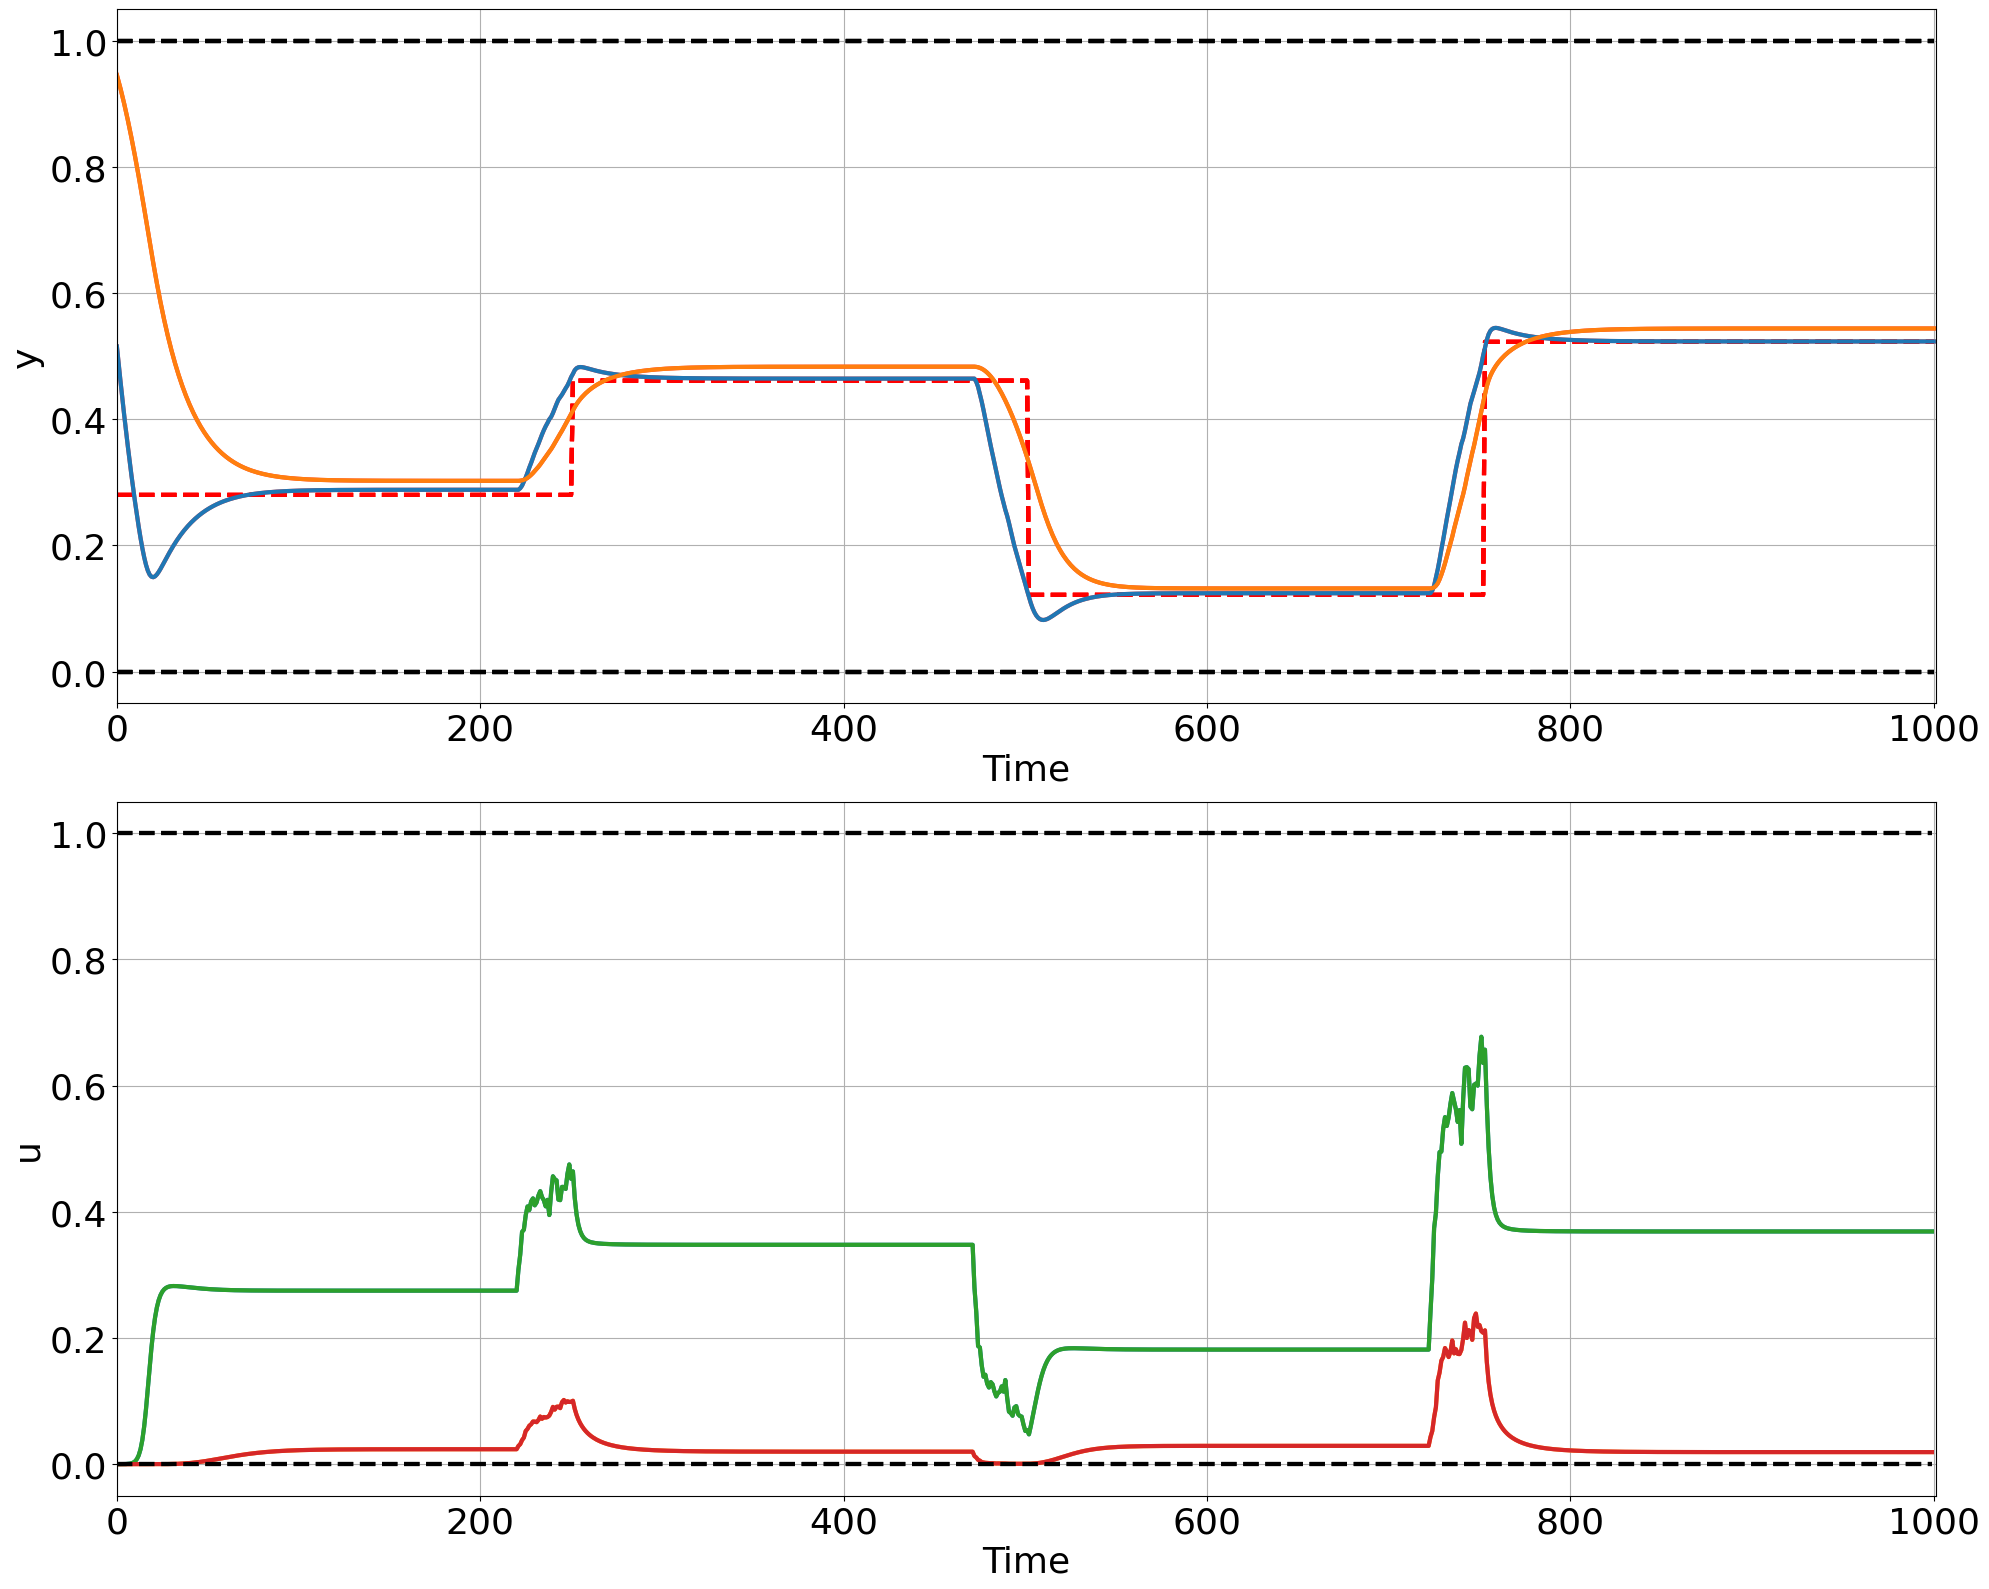

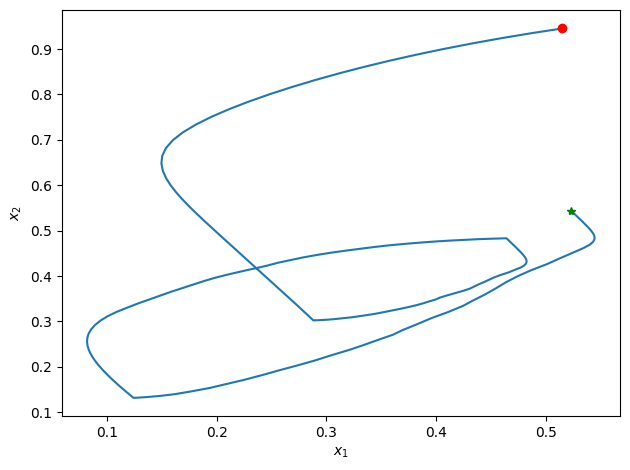

In [20]:
# closed-loop simulation with reference preview
cl_system_preview.nsteps = nsteps
trajectories_with_preview = cl_system_preview.forward(data)
pltCL(Y=trajectories_with_preview['x'].detach().reshape(nsteps + 1, nx),
        R=trajectories_with_preview['r'].detach().reshape(nsteps + 1, nref),
        U=trajectories_with_preview['u'].detach().reshape(nsteps, nu),
        Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax)
pltPhase(X=trajectories_with_preview['x'].detach().reshape(nsteps + 1, nx))